In [66]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from root_numpy import root2array
import Constants as C
from WeightTool import WeightTool

In [74]:
# Specify file path
f_numu = '../trees/NuGen_11069_Nov5_999files.root'

# Branches to load
branches = ['NPE','Nch','ImpLF_zen','cos(ImpLF_zen)','ImpLF_rchi2', 
            'nuE','NEvents','OneWeight',
            'passHESE','q_out0','q_out1','q_out2','q_in',
            'hs_z_travel','totalQ',
            'log10(hs_q_tot_pulses)', 'hm_nhit_doms','hm_nhit_strings',
            'honda2006_nue','sarcevic_std_nue',
            'honda2006_gaisserH3a_elbert_v2_numu', 
            'sarcevic_max_gaisserH3a_elbert_numu',
            'InteractionType',
            #'Qearly5','tearly5','StrNearly5','DomNearly5',
            #'Qlarge5','risetimelarge5','widthlarge5','tlarge5',
            #'xlarge5','ylarge5','zlarge5',
            #'xearly5','yearly5','zearly5',
            #'StrNlarge5','DomNlarge5', 
            'rho_travel_q', 'rho_travel',
            't_onstring','q_largest-q_onstring','t_largest-t_onstring',
            'tearly','tlarge',
            ]

# Add any selection
sel = '(NPE>1000 && nuE>0)'

# Load the data
d_numu = root2array(f_numu,treename="tree",branches=branches,selection=sel)

# Calcualte the weights
w_tool = WeightTool()
w_numuE2 = w_tool.getAstroW(d_numu['nuE'], d_numu['OneWeight'], 
                            d_numu['NEvents'], C.nugen_numu_nfiles)

# Put data into data frame
d_numu = pd.DataFrame(d_numu)

# Add weights
d_numu['w'] = pd.Series(w_numuE2)


In [81]:
# Break data set into pass and fail EHE alert
def passEHEAlert(dt):
    L3 = (dt['NPE'] > 3000) & (dt['Nch'] > 300)& (25 < dt['ImpLF_rchi2']) & (80 > dt['ImpLF_rchi2'])
    sigup = (np.cos(dt['ImpLF_zen']) < 0.1) & (np.log10(dt['NPE']) >= 3.6)
    sigdown = (np.cos(dt['ImpLF_zen']) > 0.1) & \
        (np.log10(dt['NPE'])>= 3.6 + \
        2.99 * np.sqrt( 1 - np.power((np.cos(dt['ImpLF_zen'])-0.93)/0.83,2)))
    return L3 & (sigup | sigdown)

dt_pass = d_numu[ passEHEAlert(d_numu) ]
dt_fail = d_numu[ ~passEHEAlert(d_numu) ]

# Print out the number of events
print "Passing: ", sum(dt_pass['w'])
print "Failing: ", sum(dt_fail['w'])

Passing:  2.24977861991
Failing:  34.6228107194


In [78]:
# To make things easier for plotting make dictionary
info = {'data' : [dt_pass, dt_fail],
        'col' : ['b','r'],
        'lbl' : ['Pass EHE Alert', 'Fail EHE Alert']
        }

In [79]:
# Simple method to plot basic vars
def plot(info, var, xl, yl, nbins, xmin, xmax, logy, ysf=1e-5):
    fig, ax = plt.subplots(ncols=1,figsize=(7,6))
    ymax = -9999
    for i in range(len(info['data'])):
        dt  = info['data'][i]
        col = info['col'][i]
        lbl = info['lbl'][i]
        
        bc, bins, p = plt.hist(dt[var].as_matrix(),
                               weights=dt['w'].as_matrix(),
                               bins=nbins, range=(xmin,xmax),
                               color=col, label=lbl, lw=1.5,
                               histtype='step'
                               )
        
        plt.xlabel(xl)
        plt.ylabel(yl)
        plt.tight_layout()
    
        if bc.max() > ymax:
            ymax = bc.max()
    
    if logy:
        ax.set_yscale('log')
        plt.ylim([ymax*ysf,5*ymax])
    plt.legend(loc='best')

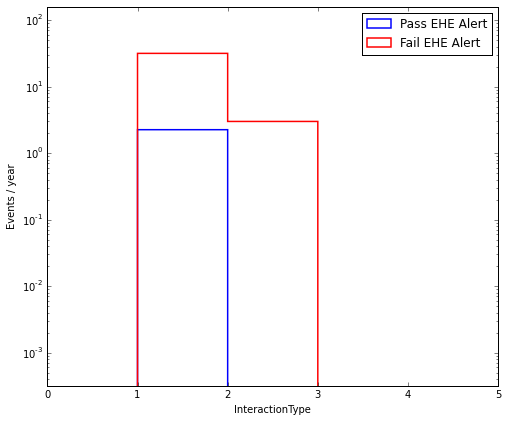

In [80]:
# Plot the interaction types so we can see we basically get
# all tracks in our track selection, and also to see what we
# are missing
plot(info,'InteractionType','InteractionType',C.lt_label,5,0,5,True)
plt.show()

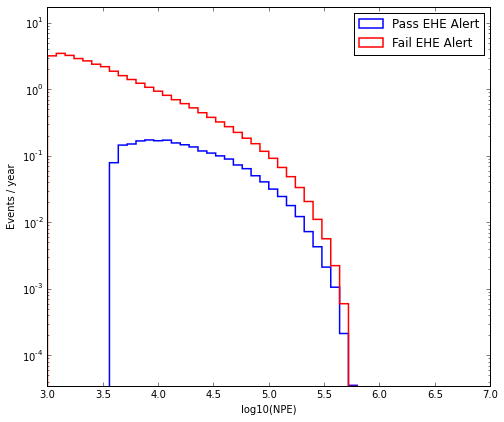

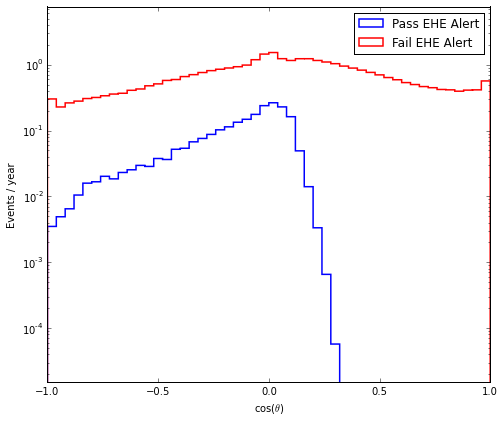

In [77]:
# What about the properties of the stuff on the outside?
plot(info,'log10(hs_q_tot_pulses)','log10(NPE)',C.lt_label,50,3,7,True)
plot(info,'cos(ImpLF_zen)',r'cos($\theta$)',C.lt_label,50,-1,1,True)
plt.show()